## Requirements:
```
conda create -n 3dpeople
source activate 3dpeople
conda install matplotlib opencv pillow scipy
conda install -c conda-forge ipywidgets=7.2.1
conda install -c plotly chart-studio
```


## Select Sequence to Visualize:

In [1]:
import numpy as np
from PIL import Image
from IPython.display import display
import scipy.io
from scipy.interpolate import interp2d
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import matplotlib.cm as colors
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import os
import glob
import gc
import cv2

%matplotlib inline

seq_name = 'woman17/02_04_jump'

# Display Utils

In [2]:
def display_imgs(imgs, title, cmap):
    num_cameras = len(imgs)
    def display_frame(frame_id):
        fig, axs = plt.subplots(1, num_cameras, figsize=(24,16))
        for camera_id in range(num_cameras):
            img = imgs[camera_id][frame_id]
            axs[camera_id].imshow(img, cmap=cmap)
            axs[camera_id].set_title(f'Camera {camera_id+1}',fontsize=20)
        axs[0].set_ylabel(title,fontsize=30)
    return display_frame

def generate_img_skeleton2d(orig_imgs, skeletons):
    if orig_imgs is None or skeletons is None:
        return None
    joints = skeletons[...,:2]
    num_cams, num_frames, num_joints, _ = joints.shape
    imgs = orig_imgs.copy()
    color_map = colors.get_cmap('Spectral')
    for camera_id in range(num_cams):
        for frame_id in range(num_frames):
            img = imgs[camera_id, frame_id, ...]
            for joint_id in range(num_joints):
                joint = tuple(joints[camera_id, frame_id, joint_id].astype(int))
                img = cv2.circle(img, joint, 2, np.array(color_map(joint_id/num_joints))*255, 2)
    return imgs

def display_skeleton3d(skeletons, camera_id, frame_id):
    init_notebook_mode(connected=True) 
    fig = go.Scatter3d(x=skeletons[camera_id, frame_id, :, -3], 
                       y=skeletons[camera_id, frame_id, :, -2], 
                       z=skeletons[camera_id, frame_id, :, -1],
                       mode='markers')
    data = [fig]
    iplot(data) 

def combine_imgs(img1, img2, alpha=0.5):
    if img1 is not None and img2 is not None:
        return ((1-alpha) * img1 + alpha * img2).astype(img1.dtype)

def interactive_display(imgs, frame_id, title, **kwargs):
    if imgs is not None:
        kwargs.setdefault("cmap", None)        
        display_frame = display_imgs(imgs, title, kwargs["cmap"])
        interact(display_frame, frame_id=frame_id)

# Read Data Utils

In [3]:
def read_samples(cameras_dir, read_f, num_cameras=4):
    cameras = []
    for camera_id in range(1, num_cameras+1):
        camera_path = os.path.join(cameras_dir, f'camera{camera_id:02d}')
        camera_data = read_f(camera_path)
        if camera_data is None:
            return None
        cameras.append(np.asarray(camera_data))
        gc.collect() 
    return np.asarray(cameras)

def read_rgbs(files_dir):
    rgbs_path = os.path.join(files_dir, '*', '*.jpg')
    files = glob.glob(rgbs_path)
    if files:
        return [np.asarray(Image.open(file)) for file in sorted(files)]

def read_depths(files_dir):
    file = os.path.join(files_dir, 'depth.mat')
    if os.path.exists(file):
        depth = scipy.io.loadmat(file)
        return [v for k, v in sorted(depth.items()) if k.startswith('depth')]

def read_normals(files_dir):
    file = os.path.join(files_dir, 'normals.mat')
    if os.path.exists(file):
        normals = scipy.io.loadmat(file)
        return [v/2+0.5 for k, v in sorted(normals.items()) if k.startswith('normals')]

def read_optical_flow(files_dir):
    file = os.path.join(files_dir, 'optical_flow.mat')
    if os.path.exists(file):
        flow = scipy.io.loadmat(file)
        return [v for k, v in sorted(flow.items()) if k.startswith('gtflow')]

def read_segmentation(files_dir):
    segmentation_path = os.path.join(files_dir,'*.png')
    files = glob.glob(segmentation_path)
    if files:
        return [np.asarray(Image.open(file).convert('RGB')) for file in sorted(files)]

def read_skeleton(files_dir):
    skeleton_path = os.path.join(files_dir,'*.txt')
    files = glob.glob(skeleton_path)
    if files:
        files.sort()
        if os.path.basename(files[0]) == "0000.txt":
            files = files[1:]
        return [np.loadtxt(file) for file in files]

# Display

In [4]:
# Read data
rgbs = read_samples(os.path.join('rgb',seq_name), read_rgbs)
depths = read_samples(os.path.join('depth_mat',seq_name), read_depths)
normals = read_samples(os.path.join('normals_mat',seq_name), read_normals)
flows = read_samples(os.path.join('optical_flow_mat',seq_name), read_optical_flow)
seg_body = read_samples(os.path.join('segmentation_body',seq_name), read_segmentation)
seg_cloth = read_samples(os.path.join('segmentation_clothes',seq_name), read_segmentation)
skeletons = read_samples(os.path.join('skeleton',seq_name), read_skeleton)

In [5]:
# Create Slider
elems = [rgbs, depths, normals, flows, seg_body, seg_cloth, skeletons]
try:
    num_frames = next(item for item in elems if item is not None).shape[1]
    frame_id = widgets.IntSlider(min=0,max=num_frames-1)
except StopIteration as e:
    frame_id = 0
    print("No data found")

In [6]:
flows_u = flows[...,0] if flows is not None else None
flows_v = flows[...,1] if flows is not None else None
normals_rgb = (normals*255).astype(rgbs.dtype) if normals is not None else None

# Display data
interactive_display(rgbs, frame_id, "RGB")
interactive_display(generate_img_skeleton2d(rgbs, skeletons), frame_id, "Joints")
interactive_display(depths, frame_id, "Depth", cmap='gray_r')
interactive_display(flows_u, frame_id, "Optical Flow U")
interactive_display(flows_v, frame_id, "Optical Flow V")
interactive_display(combine_imgs(rgbs, normals_rgb), frame_id, "Normals")
interactive_display(combine_imgs(rgbs, seg_body), frame_id, "Body Segmentation")
interactive_display(combine_imgs(rgbs, seg_cloth), frame_id, "Cloth Segmentation")

interactive(children=(IntSlider(value=0, description='frame_id', max=69), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='frame_id', max=69), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='frame_id', max=69), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='frame_id', max=69), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='frame_id', max=69), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='frame_id', max=69), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='frame_id', max=69), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='frame_id', max=69), Output()), _dom_classes=('widget-int…

In [7]:
if skeletons is not None:
    display_skeleton3d(skeletons, 0, 0)

# Transform Optical Flow

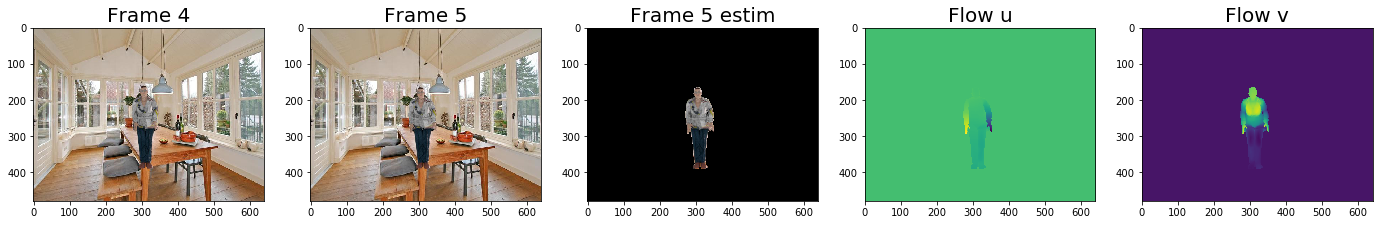

In [8]:
def transf_flow(rgb, flow):
    '''Ex use: transf_flow(rgbs[0,0,...], flows[0,1,...]) transforms rgbs[0,0,...] to rgbs[0,1,...]'''
    h, w = flow.shape[-3:-1]
    flow_cp = np.zeros_like(flow)
    flow_cp[...,0] = (flow[...,0]+np.arange(w))
    flow_cp[...,1] = (-flow[...,1]+np.arange(h)[:,np.newaxis])
    res = cv2.remap(rgb, flow_cp, None, cv2.INTER_LINEAR) * (flow[...,0:1]!=0)
    return res

if flows is not None:
    id=5
    res = transf_flow(rgbs[0,id-1,...], flows[0,id,...])
    f, axs = plt.subplots(1,5, figsize=(24,16))
    axs[0].imshow(rgbs[0,id-1,...])
    axs[0].set_title(f'Frame {id-1}',fontsize=20)
    axs[1].imshow(rgbs[0,id,...])
    axs[1].set_title(f'Frame {id}',fontsize=20)
    axs[2].imshow(res)
    axs[2].set_title(f'Frame {id} estim',fontsize=20)
    axs[3].imshow(flows[0,id,...,0])
    axs[3].set_title('Flow u',fontsize=20)
    axs[4].imshow(flows[0,id,...,1])
    axs[4].set_title('Flow v',fontsize=20)